# Stroke Prediction (Class Imbalances)

Hey there, for this project, I am taking up the dataset from Kaggle on stroke prediction. The data provided has several features (such as age, hypertension, smoking status, BMI, glucose, etc. 

Using these, I will attempt to perform extensive Data Visualisation, Exploratory Data Analysis, Feature Engineering and finally fit an ML model to make predictions on said features. Some other techniques we'll try out here are fixing class imbalances with oversampling techinques, Hyperparameter Tuning of the ML model, dealing with outliers and missing data, etc. 

I will try my best to explain each step as we go and help you understand.

## Background 
This is my first stab at a dataset with Class Imbalances and from my inital research, there are several ways to deal with them namely:
- Random Over Sampling
- Random Under Sampling
- TomekLinks
- SMOTE
- ADASYN 
and many others.

Since our data is small to begin with (being only around 5000 entries), I am avoiding undersampling techniques. Instead, I am going to be testing techniques like SMOTE, ADASYN, NearMiss to try and balance out our classes.

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from imblearn.over_sampling import SMOTE

sns.set()

In [3]:
data = pd.read_csv('./healthcare-dataset-stroke-data.csv')

## Class Imbalance

In this dataset, we encounter imbalanced data with only 5% of the data being positive for stroke. We will try different methods to counteract this problem.

Before we begin, let's understand why this is a problem in the first place. When we work with machine learning algorithm, the model learns over time coursing through the data. It looks at the data and starts to find patterns and distinguishes between them to make predictions. We track a model's effectiveness from the accuracy of the predictions. Now, if only 5% of the data is positive, the model can learn to start predicting negative values in all cases. Thus, while the model has a 95% accuracy, it cannot catch a patient having a stroke.

We need to b able to distinguish between the false negative (when the model should predict stroke but does not) and true negative values. It is okay if the models has a few false positive values (determining stroke when the patient doesn't have one) but false negative values should be avoided completely.

In [4]:
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


From the data above, there are a few things to note - hypertension, heart_disease and stroke are categorical variables. We will need to analyse those separately.

### Possible Outliers:
- There seems to be something wrong with the age column since we have a value of 0.08. 
- The BMI column should not have values of 10
- Similarly, glucose levels of 55 and 270 are concerning and might need to be adjusted.
We will look at these more closely soon.


# Plan Going Forward

- Look at the outliers and why some of the values are abnormal.
- Look at the bmi levels in the data for all 'work types' and plot against stroke variable.
- Check for correlation between variables
- Create categories for underweight and obese using bmi. Also diabetic categories for glucose levels
- Analyse relation between hypyertension, heart disease as compared to stroke detection and create histograms in different work types.

# Data Cleaning

In [5]:
data.drop(['id'], inplace=True, axis=1)

There are several ways to remove outliers. For this, I am considering using the Z-Score method if the variable is normally distributed and IQR if they're not. So, lets start by checking if age, bmi and glucose are guassian or not.

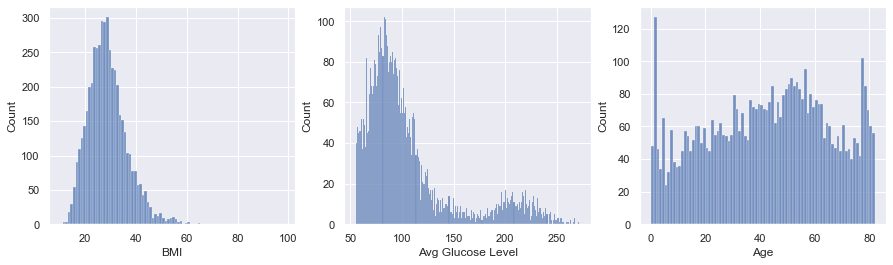

In [6]:
fig, (ax1, ax2,ax3) = plt.subplots(1,3, figsize=(15,4))

sns.histplot(data['bmi'], bins=np.arange(data['bmi'].min(), data['bmi'].max()+1), ax = ax1)
ax1.set(xlabel='BMI')
sns.histplot( data['avg_glucose_level'], bins=np.arange(data['avg_glucose_level'].min(), data['avg_glucose_level'].max()+1), ax = ax2)
ax2.set(xlabel='Avg Glucose Level')
sns.histplot(data['age'], bins=np.arange(data['age'].min(), data['age'].max()+1), ax = ax3)
ax3.set(xlabel='Age')
plt.show()

BMI and Glucose Levels seem to be Normally Distributed so we will use Z-Score to find outliers. 
However, for Age, we will use IQR.


In [7]:
def outlier_detection(data, category):
    mean = np.mean(data[category])
    sd = np.std(data[category])
    threshold = 2
    outliers = []
    for k, i in enumerate(data[category]): 
        z = (i-mean)/sd 
        if abs(z) > threshold: 
            outliers.append(k) 
    return data.drop(data.index[outliers])

data = outlier_detection(data, 'bmi')
data = outlier_detection(data, 'avg_glucose_level')

print(data['stroke'].value_counts())
print('--------------------------------')
print(data.shape)


0    4295
1     181
Name: stroke, dtype: int64
--------------------------------
(4476, 11)


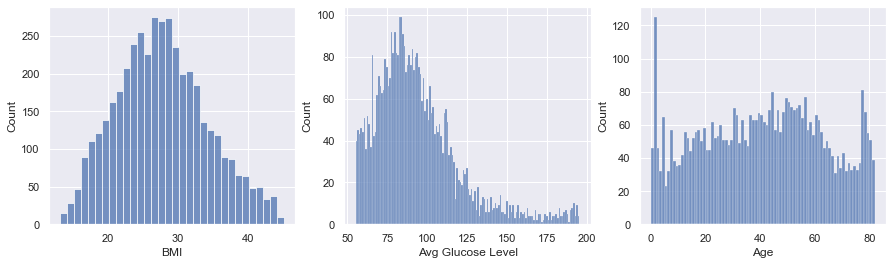

In [8]:
# Visualising the data now:
fig, (ax1, ax2,ax3) = plt.subplots(1,3, figsize=(15,4))

sns.histplot(data['bmi'], bins=np.arange(data['bmi'].min(), data['bmi'].max()+1), ax = ax1)
ax1.set(xlabel='BMI')
sns.histplot( data['avg_glucose_level'], bins=np.arange(data['avg_glucose_level'].min(), data['avg_glucose_level'].max()+1), ax = ax2)
ax2.set(xlabel='Avg Glucose Level')
sns.histplot(data['age'], bins=np.arange(data['age'].min(), data['age'].max()+1), ax = ax3)
ax3.set(xlabel='Age')
plt.show()


Now, let's move on to the age. Firstly, the age at 0 have an abnormally high number of entries. 
Moreover, the ages are in decimal. We need to clean these values as well

In [9]:


display(data[data['work_type'] == 'children'].describe())
display(data[data['age'] < 3].describe())

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,674.000000,674.0,674.000000,674.000000,660.000000,674.000000
mean,6.840534,0.0,0.001484,92.933442,20.074242,0.002967
std,4.520450,0.0,0.038519,23.746745,4.507378,0.054433
min,0.080000,0.0,0.000000,55.340000,13.200000,0.000000
25%,2.000000,0.0,0.000000,76.120000,17.200000,0.000000
50%,6.500000,0.0,0.000000,89.310000,18.900000,0.000000
75%,11.000000,0.0,0.000000,108.037500,21.525000,0.000000
max,16.000000,0.0,1.000000,194.750000,41.700000,1.000000


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,171.000000,171.0,171.000000,171.000000,165.000000,171.000000
mean,1.412398,0.0,0.005848,94.473743,18.762424,0.005848
std,0.597505,0.0,0.076472,26.121291,2.981822,0.076472
min,0.080000,0.0,0.000000,55.510000,13.300000,0.000000
25%,1.000000,0.0,0.000000,75.455000,17.000000,0.000000
50%,1.640000,0.0,0.000000,90.460000,18.500000,0.000000
75%,2.000000,0.0,0.000000,111.170000,20.300000,0.000000
max,2.000000,0.0,1.000000,170.880000,33.100000,1.000000


Looking closer at the data, we find that there are over 140 entries with children aged below 3 and this was also the reason for our extremely low BMI values. The values in decimals are the months of the children who are less than 1 year old. Thus, we won't be changing anything in this column

# Data Exploration and Visualisation

Now, we can start creating new variables and define bmi and glucose levels as categories instead which will make it easy for the model to read.
Also, let's take a look at some possible correlations that could exist.

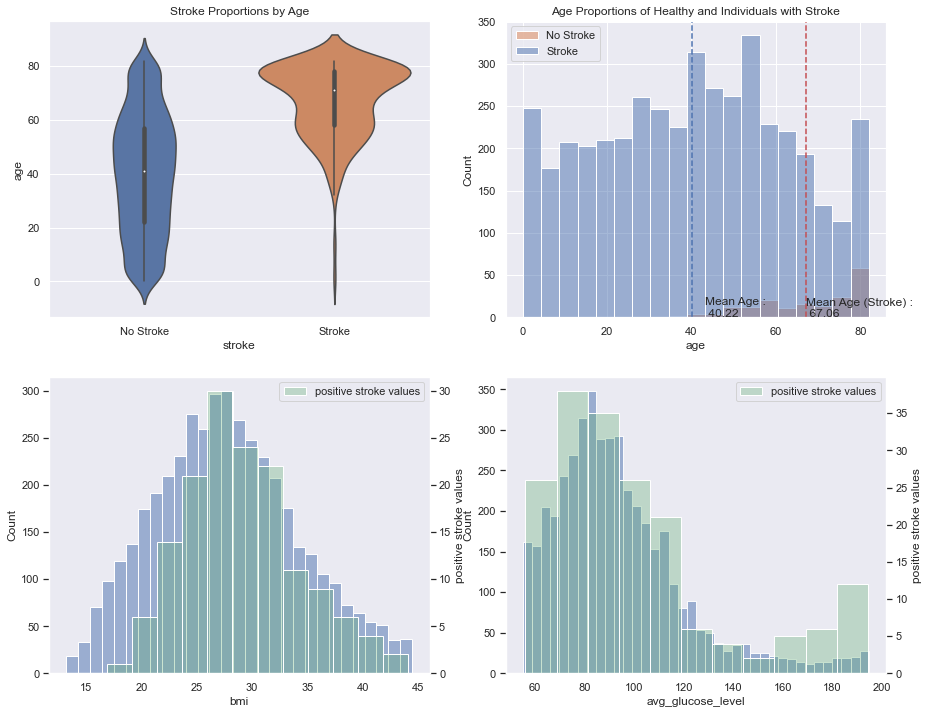

In [41]:
fig, ((ax2,ax3), (ax1, ax4)) = plt.subplots(2,2, figsize=(15,12))

sns.violinplot(x=data['stroke'], y=data['age'], ax = ax2)
ax2.set_title('Stroke Proportions by Age')
ax2.set_xticklabels( ['No Stroke', 'Stroke'])

sns.histplot(data = data, x = 'age', hue='stroke', ax = ax3)
ax3.set_title('Age Proportions of Healthy and Individuals with Stroke')
ax3.legend(loc='upper left', labels=['No Stroke', 'Stroke'])

miny_lim, y_lim = plt.ylim()
ax3.axvline(data[data['stroke']==1]['age'].mean(), linestyle='--', color='r')
ax3.axvline(data[data['stroke']==0]['age'].mean(), linestyle='--')
ax3.text(s = f"Mean Age (Stroke) : \n {data[data['stroke']==1]['age'].mean():.2f}",
         y = y_lim * 0.75, x =data[data['stroke']==1]['age'].mean() )
ax3.text(s = f"Mean Age : \n {data[data['stroke']==0]['age'].mean():.2f}",
         y = y_lim * 0.9, x =data[data['stroke']==0]['age'].mean()+3 )


edaData = data[data['stroke']==1]
sns.histplot(data = data, x = 'bmi', ax = ax1, alpha=0.5 )
ax10 = ax1.twinx()
sns.histplot(data = edaData, x = 'bmi', ax = ax10, color='g', alpha=0.3)

sns.histplot(data = data, x = 'avg_glucose_level', ax = ax4, alpha=0.5)
ax11 = ax4.twinx()
ax11.grid(False)
ax10.grid(False)
ax1.grid(False)
ax4.grid(False)
sns.histplot(data = edaData, x = 'avg_glucose_level', ax = ax11, color='g', alpha=0.3)
ax10.legend(loc='upper right', labels=['positive stroke values'])
ax10.set_ylabel('positive stroke values')

ax11.legend(loc='upper right', labels=['positive stroke values'])
ax11.set_ylabel('positive stroke values')

plt.show()


## Insights

From the plots above, we can clearly see that age plays a huge role in predicting stroke. The normal BMI and Glucose Levels are in line with the values for positive cases. Alternatively, the positive cases tend to happen for ages 40+. 

This does not mean bmi and glucose levels don't play a role. They have an effect but its not clear yet. 

In [10]:
# Note: The BMI index works as a range in combination with height and weight. Since we don't have these parameters, we will be avergaing the range and applying the BMI value.
# 0 - Underweight; 1 - Healthy; 2 - Overweight; 3 - Obese
data['obesity'] = 0
data['obesity'].loc[ data['bmi'] > 18 ] = 1
data['obesity'].loc[ data['bmi'] > 25 ] = 2
data['obesity'].loc[ data['bmi'] > 30 ] = 3

# 0 - Low; 1 - Normal; 2 - Diabetic
data['diabetic'] = 0
data['diabetic'].loc[ data['avg_glucose_level'] > 60 ] = 1
data['diabetic'].loc[ data['avg_glucose_level'] > 125 ] = 2

data['married'] = 0
data['married'].loc[ data['ever_married'] ==  'Yes' ] = 1

/Users/harshjhunjhunwala/miniconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Now that all our data is categorical, let's create dummies. Of course, we are increasing the dimensionality of the data by doing this, but it will help us analyse the model easier and make predictions more efficiently.

In [11]:
data.drop(['bmi'], inplace=True, axis=1)
data.drop(['avg_glucose_level'], inplace=True, axis=1)
data.drop(['ever_married'], inplace=True, axis=1)

In [12]:
data_encoded = pd.get_dummies(data)

In [13]:
data_encoded

,age,hypertension,heart_disease,stroke,obesity,diabetic,married,gender_Female,gender_Male,gender_Other,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
2,80.0,0,1,1,3,1,1,0,1,0,...,0,1,0,0,1,0,0,0,1,0
3,49.0,0,0,1,3,2,1,1,0,0,...,0,1,0,0,0,1,0,0,0,1
4,79.0,1,0,1,1,2,1,1,0,0,...,0,0,1,0,1,0,0,0,1,0
5,81.0,0,0,1,2,2,1,0,1,0,...,0,1,0,0,0,1,0,1,0,0
6,74.0,1,1,1,2,1,1,0,1,0,...,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,80.0,1,0,0,0,1,1,1,0,0,...,0,1,0,0,0,1,0,0,1,0
5106,81.0,0,0,0,3,2,1,1,0,0,...,0,0,1,0,0,1,0,0,1,0
5107,35.0,0,0,0,3,1,1,1,0,0,...,0,0,1,0,1,0,0,0,1,0
5108,51.0,0,0,0,2,2,1,0,1,0,...,0,1,0,0,1,0,0,1,0,0


# Class Imbalance Techniques

Now that we're done cleaning and exploring the data, let's dive into our problem of class imbalances. As mentioned earlier, less than 5% of our data is positive for strokes and that can pose an issue since the model would overfit and not generalise well.

In [14]:
from sklearn.model_selection import train_test_split

X = data_encoded.drop('stroke', axis=1)
y = data_encoded['stroke']

X_train, X_test, y_train, y_test = train_test_split( X, y, train_size=0.7, random_state=42)

## SMOTE

In [15]:
oversample = SMOTE(random_state=42)
X_smote, y_smote = oversample.fit_resample(X, y)


X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split( X_smote, y_smote, train_size=0.7, random_state=42)

## SMOTETomek

In [ ]:
from imblearn.combine import SMOTETomek 

smt = SMOTETomek(random_state=42)
X_smote, y_smote = oversample.fit_resample(X, y)


X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split( X_smote, y_smote, train_size=0.7, random_state=42)

## SMOTEENN

In [17]:
print('original train', X_train.shape, y_train.shape)
print('smote train', X_train_smote.shape, y_train_smote.shape)

print('original test', X_test.shape, y_test.shape)
print('smote test', X_test_smote.shape, y_test_smote.shape)


original train (3133, 20) (3133,)
smote train (6013, 20) (6013,)
original test (1343, 20) (1343,)
smote test (2577, 20) (2577,)


# Building the model

Let's start with some classification models that would do well with this data and narrow down from there. These are the next steps:
- Out of these, which model to finally choose. Why?
- Hyperparameter Tuning for the chosen model to imporve performance
- Check predictions. Are they learning to only predict 0 and getting a high accuracy? Compare results with oversampled data.
- How else can we improve accuracy? Maybe try further Data Cleaning and Encoding?

In [38]:
# models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from collections import Counter


# metrics and pickle
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import pickle

In [19]:
# Data without SMOTE

model_dict = {
    'Logistic Reg': LogisticRegression(random_state=0, max_iter=350, solver='lbfgs'),
    'Naive Bayes': GaussianNB(), 
    'Stochastic Grad Descent': SGDClassifier(random_state=0), 
    'Random Forest Classifier': RandomForestClassifier(random_state=0),
    'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=0),
    'Support Vector Machine': SVC(random_state=0),
    'K Nearest Classifier': KNeighborsClassifier(),
    'Decison Tree': DecisionTreeClassifier(random_state=0)
            }
model_list = []
train_acc_list = []
test_acc_list = []
counter_list = []

for model, clf in model_dict.items():
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, predictions)
    train_pred =  clf.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    counter = Counter(predictions)
    
    model_list.append(model)
    train_acc_list.append(train_acc)
    test_acc_list.append(acc)   
    counter_list.append(counter)
    

results = pd.DataFrame({"model": model_list, "train_accuracy": train_acc_list, "test_acc": test_acc_list, 'counter': counter_list})


In [20]:
display(results)
Counter(y_test)

,model,train_accuracy,test_acc,counter
0,Logistic Reg,0.961379,0.956069,"{0: 1342, 1: 1}"
1,Naive Bayes,0.532397,0.554728,"{0: 699, 1: 644}"
2,Stochastic Grad Descent,0.924992,0.925540,"{0: 1265, 1: 78}"
3,Random Forest Classifier,0.995531,0.948622,"{0: 1330, 1: 13}"
4,Gradient Boosting Classifier,0.968082,0.956813,"{0: 1337, 1: 6}"
5,Support Vector Machine,0.961379,0.955324,{0: 1343}
6,K Nearest Classifier,0.962975,0.956069,"{0: 1340, 1: 3}"
7,Decison Tree,0.995531,0.928518,"{0: 1293, 1: 50}"


Counter({0: 1283, 1: 60})

As shown above, the true values of y_test show 60 positive detections of stroke and most of our models are overfitting and prediciting negative results(0). Decision Tree and Stochastic Grad Desc seem to be the only ones having higher values of positive predictions (1) but we need to see if these predictions are actually accurate. 

In [22]:
y_test_analys = y_test.reset_index().drop('index', axis=1)
index = y_test_analys.index[y_test_analys['stroke'] == 1]
print('predictions by Dec Tree model for all positive true values:  ', Counter(predictions[index]) )
print('All predictions by Dec Tree model:  ', Counter(predictions) )

predictions by Dec Tree model for all positive true values:   Counter({0: 53, 1: 7})
All predictions by Dec Tree model:   Counter({0: 1293, 1: 50})


### Initial Model Thoughts
Even our most promising model, the Decision Tree, predicted only 7 correct values. It had 50 positive predictions out which 86% of the predictions were incorrect. Similar results are seen for other models as well. 

Thus we cannot use these models at the moment. We will see the results after customising the models and testing the SMOTE data. 

In [59]:
# Let's take a look at results using SMOTE

model_dict = {
    'Logistic Reg': LogisticRegression(random_state=0, max_iter=550, solver='lbfgs'),
    'Naive Bayes': GaussianNB(), 
    'Stochastic Grad Descent': SGDClassifier(random_state=0), 
    'Random Forest Classifier': RandomForestClassifier(random_state=0),
    'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=0),
    'Support Vector Machine': SVC(random_state=0),
    'K Nearest Classifier': KNeighborsClassifier(),
    'Decison Tree': DecisionTreeClassifier(random_state=0)
            }
model_list = []
train_acc_list = []
test_acc_list = []
counter_list = []
prediction_list = []
metric_scores_list = []

for model, clf in model_dict.items():
    clf.fit(X_train_smote, y_train_smote)
    predictions = clf.predict(X_test_smote)
    acc = accuracy_score(y_test_smote, predictions)
    train_pred =  clf.predict(X_train_smote)
    train_acc = accuracy_score(y_train_smote, train_pred)
    counter = Counter(predictions)
    report = precision_recall_fscore_support(y_test_smote, predictions, average='binary')
    report_values =  ("precision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f" % \
           (report[0], report[1], report[2], acc))

    path = './models/' + model
    with open(path, 'wb') as f:
        pickle.dump(clf, f)
    
    model_list.append(model)
    train_acc_list.append(train_acc)
    test_acc_list.append(acc)   
    counter_list.append(counter)
    prediction_list.append(predictions)
    metric_scores_list.append(report_values)
    

results = pd.DataFrame({"model": model_list, "train_accuracy": train_acc_list, "test_acc": test_acc_list,'metric':metric_scores_list, 'counter': counter_list, 'predictions': prediction_list})


In [60]:
display(results) 
Counter(y_test_smote)

,model,train_accuracy,test_acc,metric,counter,predictions
0,Logistic Reg,0.941460,0.938300,"precision = 0.96, recall = 0.91, F1 = 0.94, ac...","{0: 1353, 1: 1224}","[0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, ..."
1,Naive Bayes,0.640778,0.623981,"precision = 0.57, recall = 0.97, F1 = 0.72, ac...","{1: 2186, 0: 391}","[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, ..."
2,Stochastic Grad Descent,0.827540,0.824214,"precision = 0.92, recall = 0.71, F1 = 0.80, ac...","{0: 1585, 1: 992}","[0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, ..."
3,Random Forest Classifier,0.998503,0.972061,"precision = 0.97, recall = 0.97, F1 = 0.97, ac...","{0: 1300, 1: 1277}","[0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, ..."
4,Gradient Boosting Classifier,0.956760,0.948778,"precision = 0.96, recall = 0.94, F1 = 0.95, ac...","{0: 1320, 1: 1257}","[0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, ..."
5,Support Vector Machine,0.786629,0.788126,"precision = 0.75, recall = 0.86, F1 = 0.80, ac...","{0: 1104, 1: 1473}","[0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, ..."
6,K Nearest Classifier,0.955097,0.937912,"precision = 0.90, recall = 0.98, F1 = 0.94, ac...","{0: 1178, 1: 1399}","[0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, ..."
7,Decison Tree,0.998503,0.951494,"precision = 0.95, recall = 0.96, F1 = 0.95, ac...","{0: 1279, 1: 1298}","[0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, ..."


Counter({0: 1292, 1: 1285})

Now, we start seeing results resemble the true value number more. Let's see how accurate they are:

In [61]:
y_test_analys_smote = y_test_smote.reset_index().drop('index', axis=1)
index = y_test_analys_smote.index[y_test_analys_smote['stroke'] == 1]
print('predictions by Dec Tree model for all true values being positive:  ', Counter(predictions[index]) )
print('all predictions by Dec Tree model:  ', Counter(predictions) )

predictions by Dec Tree model for all true values being positive:   Counter({1: 1229, 0: 56})
all predictions by Dec Tree model:   Counter({1: 1298, 0: 1279})


Finally, we start to see much better results! Using the Decision Tree model again, our positive values match correctly for over 95% of the values.

We can start Hyperparameter Tuning on some of the models to improve the performance and finally select one. Let's start with the Random Forest model owing to its high 97% test accuracy along with a precision and recall of 97%.

Next, we will look at the Decision Tree model with test accuracy of 95% and precision and recall of 96%

# HyperParameter Tuning

In [72]:
rf = RandomForestClassifier(random_state=0)

print('Parameters currently in use:\n')
print(rf.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


In [77]:
from sklearn.model_selection import RandomizedSearchCV


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2',1,2,3]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'max_features': ['auto', 'sqrt', 'log2', 1, 2, 3], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [78]:
# Use the random grid to search for best hyperparameters

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [79]:
rf_random.fit(X_train_smote, y_train_smote)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 50,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 100,
 'bootstrap': False}

In [86]:
rf = RandomForestClassifier(bootstrap= False, max_depth=100, max_features= 'log2', min_samples_leaf = 1, 
                            min_samples_split=5, n_estimators= 50)

rf.fit(X_train_smote, y_train_smote)
final_pred = rf.predict(X_test_smote)
acc = accuracy_score(y_test_smote, final_pred)
report = precision_recall_fscore_support(y_test_smote, predictions, average='binary')
report_values =  ("precision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f" % \
           (report[0], report[1], report[2], acc))

print(report_values)


precision = 0.97, recall = 0.97, F1 = 0.97, accuracy = 0.97


In [87]:
rf.feature_importances_

array([3.81082730e-01, 9.57773540e-03, 1.14251058e-02, 7.45787119e-02,
       2.27199924e-02, 2.46503349e-02, 3.68648094e-02, 3.61667629e-02,
       8.59875297e-05, 3.23926259e-02, 6.01121174e-04, 4.23534903e-02,
       2.87874132e-02, 2.96585212e-02, 4.08930552e-02, 4.29893266e-02,
       6.42756825e-02, 3.74368383e-02, 4.82989354e-02, 3.51608202e-02])

# Next Steps

Take a look at feature importance in more detail using 
- SHAP
- LIME
- ELI-5

Try other Class Imbalance Methods and see which performs best.